Q. gridsearch란 무엇이고 사용 방법에 대해 설명하라

A. 모델의 최적 하이퍼 파라미터를 찾기 위한 기법 중 하나  
      => 다른 방법은? 
  => 이 중에서 gridsearch를 설명한 이유?

사용방법
1. 하이퍼 파라미터 그리드 생성
2. 정의한 하이퍼 파라미터 그리드 기반으로 가능한 모든 조합을 탐색하여 조합을 여러번 학습하며 각 조합에 대해 교차 검증을 수행
3. 교차검증을 통해 나온 조합의 성능을 평가. 이 때 평가 지표로 정확도, 정밀도, 재현율, f1 score 등 다양한 성능 평가 지표를 사용 가능함
4. 가장 우수한 성능을 보이는 하이퍼 파라미터 조합을 선택하고 해당 조합으로 최종 모델을 학습

장점
1. 구현이 간단하고 직관적이며 사용하기 쉬움
2. 모든 하이퍼파라미터 조합을 탐색
3. 평가 지표를 기반으로 최적화

단점
1. 그리드에 포함된 모든 조합을 탐색하기 때문에 계산 비용이 높음
2. 튜닝할 하이퍼 파라미터 수의 제한
3. 하이퍼 파라미터간의 관계를 고려하지 않고 독립적으로 탐색

=> 단점 해결 방법?

배깅이 약한 학습기 합치는 방식, 부스팅이 모델 1개를 예측하고 부정적인 샘플에 가중치줘서 점차 성능이 좋아지도록 훈련시키는 (샘플에 가중치 부여!) 방식.. 

gradient boosting: 잔차의 오차를 줄여가며 모델 강화

# 산탄데르 고객 만족 예측
* ROC-AUC로 평가 (대부분이 만족이고 불만족인 데이터는 일부일 것으로 추정됨(불균형(imbalanced)이 심한 데이터))

## XGBoost
트리 기반의 앙상블 학습 알고리즘 중 하나로, 대용량 데이터셋에서 높은 성능을 내는 데 특히 효과적

## 데이터 전처리

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('data/Customers_Satisfaction.csv')

In [10]:
# 데이터 확인
print(cust_df.shape)
cust_df.head()

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [15]:
# TARGET 컬럼 불만족인값(1)의 갯수와 비율 확인
print(cust_df['TARGET'].value_counts())
print(cust_df['TARGET'].value_counts()[1]/len(cust_df))

0    73012
1     3008
Name: TARGET, dtype: int64
0.0395685345961589


In [19]:
cust_df['var3'].mode()

0    2
Name: var3, dtype: int64

In [22]:
# var3 컬럼에서 이상값 찾고 이상값을 가장 빈도수가 높은 값으로 바꾸기
cust_df['var3'].describe()

cust_df.loc[cust_df['var3'] == -999999, 'var3']= 2

In [23]:
cust_df['var3'].describe()

count    76020.000000
mean         2.716483
std          9.447971
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        238.000000
Name: var3, dtype: float64

In [24]:
# 불필요한 컬럼(ID) 삭제
cust_df = cust_df.drop(columns=['ID'])

In [30]:
# 피쳐 세트와 레이블 세트 분리. 슬라이싱을 사용해 분리할 것. y_label은 df의 마지막 컬럼
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피쳐 데이터 shape : {0}'.format(X_features.shape))

피쳐 데이터 shape : (76020, 369)


In [41]:
#학습/테스트 데이터셋 분리
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(X_features, y_labels)

In [56]:
help(XGBClassifier.fit)

Help on function fit in module xgboost.sklearn:

fit(self, X: Any, y: Any, *, sample_weight: Optional[Any] = None, base_margin: Optional[Any] = None, eval_set: Optional[Sequence[Tuple[Any, Any]]] = None, eval_metric: Union[str, Sequence[str], Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]], NoneType] = None, early_stopping_rounds: Optional[int] = None, verbose: Union[bool, int, NoneType] = True, xgb_model: Union[xgboost.core.Booster, str, xgboost.sklearn.XGBModel, NoneType] = None, sample_weight_eval_set: Optional[Sequence[Any]] = None, base_margin_eval_set: Optional[Sequence[Any]] = None, feature_weights: Optional[Any] = None, callbacks: Optional[Sequence[xgboost.callback.TrainingCallback]] = None) -> 'XGBClassifier'
    Fit gradient boosting classifier.
    
    Note that calling ``fit()`` multiple times will cause the model object to be
    re-fit from scratch. To resume training from a previous checkpoint, explicitly
    pass ``xgb_model`` argument.
    
    Para

## XGBoost 모델 학습과 하이퍼 파라미터 튜닝

In [54]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
xgb_clf = XGBClassifier()
#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(x_tr, y_tr, early_stopping_rounds=100, eval_metrics='auc')
xgb_clf.fit(x_tr, y_tr)

# roc_score 구하기
xgb_roc_score = roc_auc_score(y_t)
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

TypeError: fit() got an unexpected keyword argument 'eval_metrics'

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either est

In [50]:
# 하이퍼 파리미터 튜닝
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 설정
xgb_clf = XGBClassifier(n_estimators=100)

# 파라미터는 max_depth, min_child_weight, colsample_bytree를 사용
params = {max_depth=[10,20,30], min_child_weight= [0,1,2], colsample_bytree=[0.1,0.5, 0.8]
    
}

# cv는 3으로 지정
gridcv = GridSearchCV(cv=3)

# 조기 중단 30, 평가지표로 auc 활용해 gridcv 학습 -> 실행하지 말 것
# gridcv.fit()

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
#약 15분 소요

# 결과
# GridSearchCV 최적 파라미터 :  {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_weight': 3}
# ROC AUC : 0.8445

TypeError: __init__() missing 2 required positional arguments: 'estimator' and 'param_grid'

In [53]:
# 위 결과와 아래 값을 토대로 최적의 파라미터를 가진 새로운 모델 생성
# n_estimators는 1000, learning_rates는0.02, reg_alpha=0.03
xgb_clf = XGBClassifier(n_estimators=1000, max_depth=10, reg_alpha=0.03)

#성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하는 학습 수행
xgb_clf.fit(x_tr, y_tr)

xgb_roc_score = roc_auc_score()
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

# ROC AUC : 0.8453

[16:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "learning_rates" } are not used.



TypeError: roc_auc_score() missing 2 required positional arguments: 'y_true' and 'y_score'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

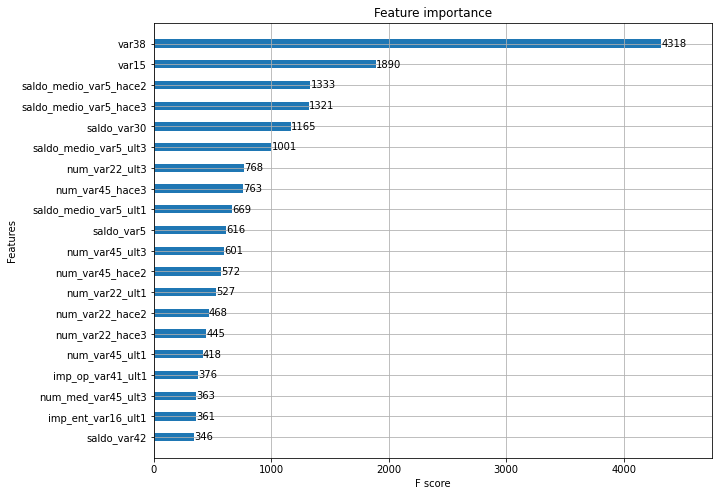

In [36]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# xgboost plot_importance를 사용해 중요 feature 그래프 그리기
plot_importance()

In [37]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

In [ ]:
#GridSearchCV로 더 다양한 하이퍼 파라미터 튜닝 수행
from sklearn.model_selection import GridSearchCV

#하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators=200)

params = {
    'num_leaves' : [32, 64],
    'max_depth' : [128, 160],
    'min_child_samples' : [60, 100],
    'subsample' : [0.8, 1]
}

#cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

# GridSearchCV 최적 파라미터 :  {'max_depth': 128, 'min_child_samples': 100, 'num_leaves': 32, 'subsample': 0.8}
# ROC AUC : 0.8417

In [40]:
#해당 하이퍼 파라미터를 LightGBM에 적용 후 다시 학습해 ROC-AUC 측정 결과 도출
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, subsample=0.8, min_child_samples=100, max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.1